# P-values in GWAS

In [1]:
using Distributions
using DataFrames
using GLM
using Plots, Measures, StatsPlots
using StatsPlots
using Printf

# Default plot settings
gr(html_output_format=:png); # Avoid SVG and forcing PNG format for plots

## 2.1 What is P-value?

In [2]:
n = 100
f = 0.30 # MAF
x = rand(Binomial(2, f), n) # example genotypes for n individuals
y = randn(n) # outcome that is independent of x
lm_fit = lm(@formula(y ~ x), DataFrame("x"=>x, "y"=>y, copycols=false))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   0.0911801    0.142018   0.64    0.5224  -0.190651   0.373011
x            -0.0480635    0.16737   -0.29    0.7746  -0.380205   0.284078
──────────────────────────────────────────────────────────────────────────

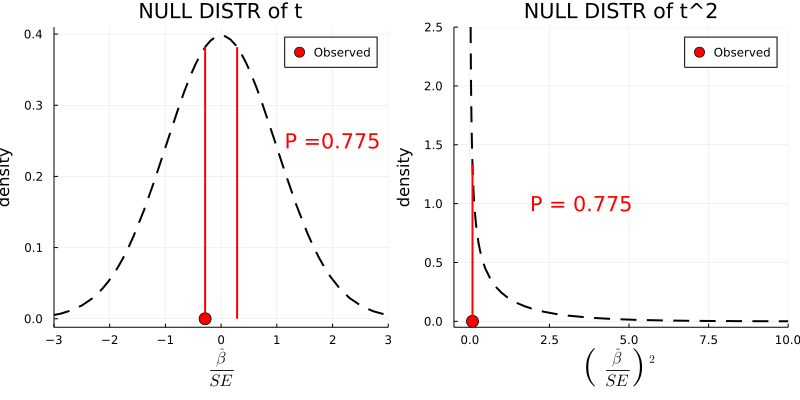

In [3]:
p = plot(layout=(1, 2), size=(800, 400), bottom_margin=7mm) # draw two panel on the grid with 1 row and 2 cols

coef_values = coeftable(lm_fit)
t_stat = coef_values.cols[coef_values.teststatcol][coef_values.rownms.=="x"][1] # Extract t-value for variable 'x'
p_val = coef_values.cols[coef_values.pvalcol][coef_values.rownms.=="x"][1]

#1 on t-statistic's scale
# x_grid = range(-3.0, +3.0, 0.05) # we need to define the plotting regio
plot!(p, TDist(n-2), label=nothing, lw=2, ls=:dash, lc=:black,
    xaxis=("\$\\frac{\\hat{\\beta}}{SE}\$", (-3, +3)),
    yaxis=("density")
)
scatter!(p, [t_stat], [0], color=:red, markersize=7, label="Observed")
plot!(p, t_stat * [1, 1], [0, pdf(TDist(n-2), t_stat)], lw=2, lc=:red, label=nothing)
plot!(p, -t_stat * [1, 1], [0, pdf(TDist(n-2), t_stat)], lw=2, lc=:red, label=nothing)
annotate!(2.0, 0.25, text(@sprintf("P =%.3f", p_val), :red), subplot=1)
title!(p, "NULL DISTR of t")

#2nd of t^2 statistics
plot!(p, Chisq(1), label=nothing, lw=2, ls=:dash, lc=:black,
    xaxis=("\$\\left(\\frac{\\hat{\\beta}}{SE}\\right)^2\$", (-0.5, 10)),
    yaxis=("density", (-0.05, 2.5)),
    subplot=2
)
scatter!(p, [t_stat^2], [0], color=:red, markersize=7, label="Observed", subplot=2)
plot!(p, t_stat^2 * [1, 1], [0, pdf(Chisq(1), t_stat^2)], lw=2, lc=:red, label=nothing, subplot=2)
annotate!(3.5, 1, text(@sprintf("P = %.3f", p_val), :red), subplot=2)
title!(p, "NULL DISTR of t^2", subplot=2)

In [4]:
z = t_stat # t-statistic is also called z-score under Normal approximation
cdf(Normal(), -abs(z)) + ccdf(Normal(), abs(z))

0.7739831557621202

In [5]:
ccdf(Chisq(1), t_stat^2)

0.7739831557621203

## 2.2 Distribution of P-values

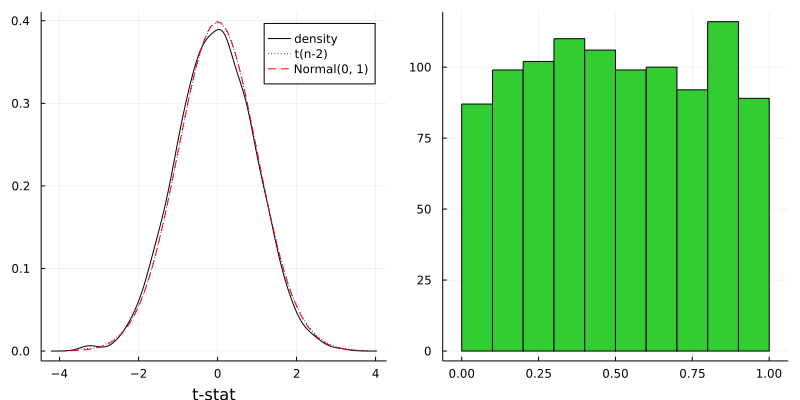

In [6]:
n = 100 # individuals
p = 1000 # variants measured on each individual
f = 0.40 # MAF is assumed the same for all variants; does not actually matter here
X = rand(Binomial(2, f), (n, p)) # just random genotypes
y = randn(n) # pheonotype that is not associated with any genotype

lm_res = [lm(@formula(x ~ y), DataFrame("x"=>X[:,i], "y"=>y, copycols=false)) |> # compute linear model
    coeftable |> # get coefficents
    c -> [c.cols[3][2], c.cols[4][2]] # extract t-stat and p-value for "x"
    for i ∈ 1:p] # for all 'p' variants

t_stats = [x[1] for x ∈ lm_res]
p_vals = [x[2] for x ∈ lm_res]

fig = plot(layout=(1, 2), size=(800, 400))
density!(fig, t_stats, lwd=2, lc=:black, xaxis=("t-stat"), label="density", subplot=1)
plot!(fig, TDist(n-2), lc=:blue, ls=:dot, label="t(n-2)", subplot=1)
plot!(fig, Normal(), lc=:red, ls=:dash, label="Normal(0, 1)", subplot=1)
histogram!(fig, p_vals, subplot=2, color=:limegreen, label=nothing)

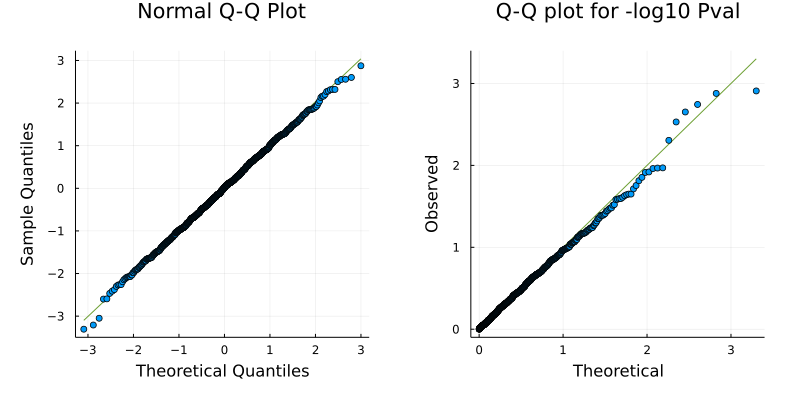

In [7]:
fig = plot(layout=(1, 2), size=(800, 400), margin=7mm)
qqnorm!(fig, subplot=1, t_stats, qqline=:R,
    xaxis=("Theoretical Quantiles"), yaxis=("Sample Quantiles"),
    title=("Normal Q-Q Plot")
)

# For P-values, we want to comapre to the uniform(0, 1) distribution
# We need to get p-equally spaced values in (0, 1) to represent quantiles
# of Uniform(0, 1)
# We take -log10 transformation to see small P-values particularly well
qqplot!(fig, subplot=2, -log10.((0.5:1:p) ./ p), -log10.(p_vals), qqline=:identity,
    xaxis=("Theoretical"), yaxis=("Observed"),
    title=("Q-Q plot for -log10 Pval")
)

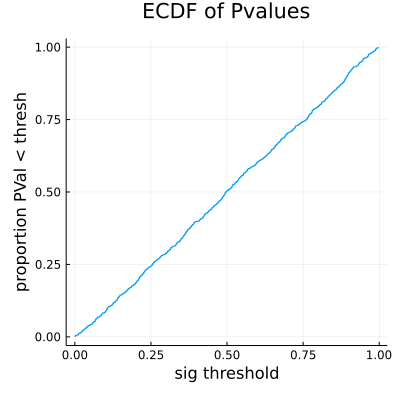

In [8]:
ecdfplot(p_vals, label=nothing,
    xlabel="sig threshold", ylab="proportion PVal < thresh",
    title="ECDF of Pvalues", size=(400, 400)
)

In [9]:
sum(p_vals .< 0.05)

40

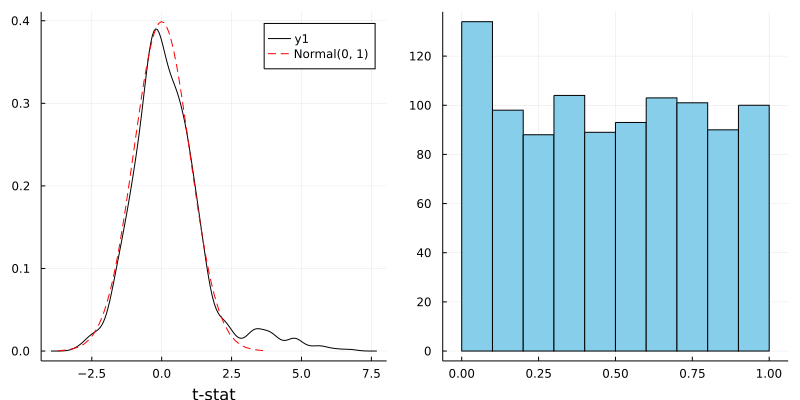

In [10]:
n = 1000 # individuals
p = 1000 # genotypes measured on each individual
m = 50 # number of variants that have an effect; they are x_1, ...x_m
f = 0.4 # MAF
b = 0.5 # effect size of variants that have an effect
X = rand(Binomial(2, f), (n, p))
y = X[:, 1:m] * fill(b, m) + randn(n)

lm_res = [lm(@formula(x ~ y), DataFrame("x"=>X[:,i], "y"=>y, copycols=false)) |> # compute linear model
    coeftable |> # get coefficents
    c -> [c.cols[3][2], c.cols[4][2]] # extract t-stat and p-value for "x"
    for i ∈ 1:p] # for all 'p' variants

t_stats = [x[1] for x ∈ lm_res]
p_vals = [x[2] for x ∈ lm_res]

fig = plot(layout=(1, 2), size=(800, 400))
density!(fig, t_stats, lwd=2, lc=:black, xaxis=("t-stat"), subplot=1)
plot!(fig, Normal(), lc=:red, ls=:dash, label="Normal(0, 1)", subplot=1)
histogram!(fig, p_vals, subplot=2, color=:skyblue, label=nothing)

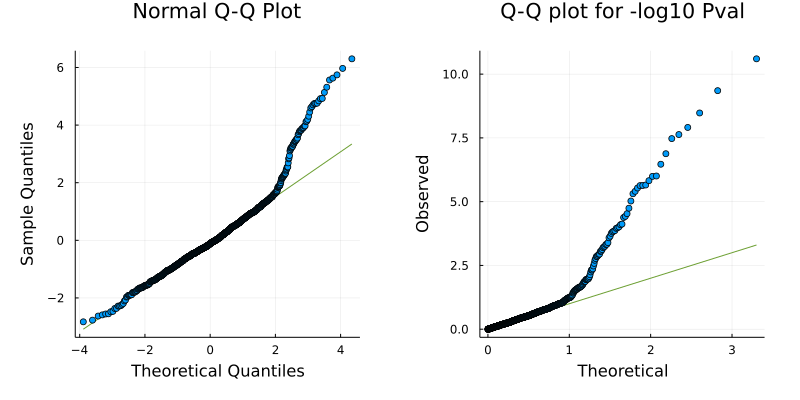

In [11]:
fig = plot(layout=(1, 2), size=(800, 400), margin=7mm)
qqnorm!(fig, subplot=1, t_stats, qqline=:R,
    xaxis=("Theoretical Quantiles"), yaxis=("Sample Quantiles"),
    title=("Normal Q-Q Plot")
)

qqplot!(fig, subplot=2, -log10.((0.5:1:p) ./ p), -log10.(p_vals), qqline=:identity,
    xaxis=("Theoretical"), yaxis=("Observed"),
    title=("Q-Q plot for -log10 Pval")
)

In [12]:
p_T = 1e-6
prior_odds = p_T / (1 - p_T)
pwr = 1 # upper bound for power --> upper bound for alpha
post_odds = 0.95 / (1 - 0.95)
alpha = prior_odds * pwr / post_odds

5.263163157900004e-8